### Exaplanatory Data Analysis on Timeseries Stock Market Data

In [104]:
import numpy as np
import pandas as pd
import os, datetime
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.9.2


In [105]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15374258513308929246
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4222422749843390871
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [106]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[1:], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [107]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [108]:
df = pd.read_csv(r'/content/HistoricalData_Metaverse.csv')
df

,Date,Close/Last,Volume,Open,High,Low
0,11/30/2022,$118.1,43348560,$109.505,$118.16,$109.38
1,11/29/2022,$109.46,23899240,$109.54,$110.94,$108.5437
2,11/28/2022,$108.78,23332820,$110.78,$112.04,$108.38
3,11/25/2022,$111.41,12007570,$111.3,$112.73,$111.02
4,11/23/2022,$112.24,21343080,$111.72,$112.67,$110.73
...,...,...,...,...,...,...
2512,12/07/2012,$27.485,51648160,$27.07,$27.78,$26.84
2513,12/06/2012,$26.97,45933360,$27.68,$27.75,$26.82
2514,12/05/2012,$27.71,58899760,$27.75,$27.9,$27.26
2515,12/04/2012,$27.46,72810360,$27.06,$27.76,$26.68


In [109]:
df = df.rename(columns={'Close/Last':'Close'})

In [110]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

## Preprocessing

In [111]:
df.Date = pd.to_datetime(df.Date)
df['Close'] = df['Close'].apply(lambda x: x.split('$')[1]) 
df['Open'] = df['Open'].apply(lambda x: x.split('$')[1]) 
df['High'] = df['High'].apply(lambda x: x.split('$')[1]) 
df['Low'] = df['Low'].apply(lambda x: x.split('$')[1]) 
df

,Date,Open,High,Low,Close,Volume
0,2022-11-30,109.505,118.16,109.38,118.1,43348560
1,2022-11-29,109.54,110.94,108.5437,109.46,23899240
2,2022-11-28,110.78,112.04,108.38,108.78,23332820
3,2022-11-25,111.3,112.73,111.02,111.41,12007570
4,2022-11-23,111.72,112.67,110.73,112.24,21343080
...,...,...,...,...,...,...
2512,2012-12-07,27.07,27.78,26.84,27.485,51648160
2513,2012-12-06,27.68,27.75,26.82,26.97,45933360
2514,2012-12-05,27.75,27.9,27.26,27.71,58899760
2515,2012-12-04,27.06,27.76,26.68,27.46,72810360


In [112]:
## Change dtypes to float
df.iloc[:,1:] = df.iloc[:,1:].astype(np.float32) 
df['Volume'] = df['Volume'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Open    2517 non-null   float32       
 2   High    2517 non-null   float32       
 3   Low     2517 non-null   float32       
 4   Close   2517 non-null   float32       
 5   Volume  2517 non-null   int64         
dtypes: datetime64[ns](1), float32(4), int64(1)
memory usage: 78.8 KB


In [113]:
df

,Date,Open,High,Low,Close,Volume
0,2022-11-30,109.504997,118.160004,109.379997,118.099998,43348560
1,2022-11-29,109.540001,110.940002,108.543701,109.459999,23899240
2,2022-11-28,110.779999,112.040001,108.379997,108.779999,23332820
3,2022-11-25,111.300003,112.730003,111.019997,111.410004,12007570
4,2022-11-23,111.720001,112.669998,110.730003,112.239998,21343080
...,...,...,...,...,...,...
2512,2012-12-07,27.070000,27.780001,26.840000,27.485001,51648160
2513,2012-12-06,27.680000,27.750000,26.820000,26.969999,45933360
2514,2012-12-05,27.750000,27.900000,27.260000,27.709999,58899760
2515,2012-12-04,27.059999,27.760000,26.680000,27.459999,72810360


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6d8a3beb0>,
      dtype=object)

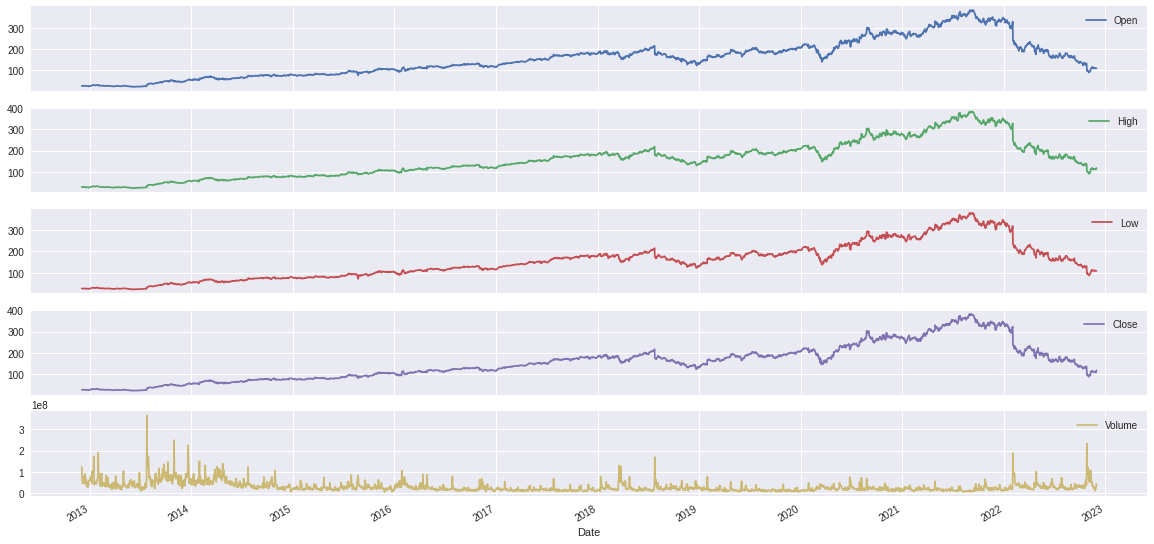

In [114]:
df.plot(x='Date',subplots=True, figsize=(20,10))

In [115]:
df.describe()

,Open,High,Low,Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,154.838745,156.786255,152.897079,154.876038,2.987092e+07
std,84.601265,85.674881,83.556854,84.623283,2.369119e+07
min,22.990000,23.090000,22.670000,22.899000,5.913066e+06
25%,82.830002,83.690002,82.209999,82.904999,1.593675e+07
50%,151.690002,153.309998,149.630005,151.380005,2.253079e+07
75%,194.699997,197.367203,192.119995,194.470001,3.469755e+07
max,381.679993,384.329987,378.809998,382.179993,3.650917e+08


In [116]:
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
4,2022-11-23,111.720001,112.669998,110.730003,112.239998,21343080
3,2022-11-25,111.300003,112.730003,111.019997,111.410004,12007570
2,2022-11-28,110.779999,112.040001,108.379997,108.779999,23332820
1,2022-11-29,109.540001,110.940002,108.543701,109.459999,23899240
0,2022-11-30,109.504997,118.160004,109.379997,118.099998,43348560


In [117]:
df.reset_index(drop=True,inplace=True)
df

,Date,Open,High,Low,Close,Volume
0,2012-12-03,28.000000,28.879999,26.980000,27.040001,123384896
1,2012-12-04,27.059999,27.760000,26.680000,27.459999,72810360
2,2012-12-05,27.750000,27.900000,27.260000,27.709999,58899760
3,2012-12-06,27.680000,27.750000,26.820000,26.969999,45933360
4,2012-12-07,27.070000,27.780001,26.840000,27.485001,51648160
...,...,...,...,...,...,...
2512,2022-11-23,111.720001,112.669998,110.730003,112.239998,21343080
2513,2022-11-25,111.300003,112.730003,111.019997,111.410004,12007570
2514,2022-11-28,110.779999,112.040001,108.379997,108.779999,23332820
2515,2022-11-29,109.540001,110.940002,108.543701,109.459999,23899240


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6d3dff520>,
      dtype=object)

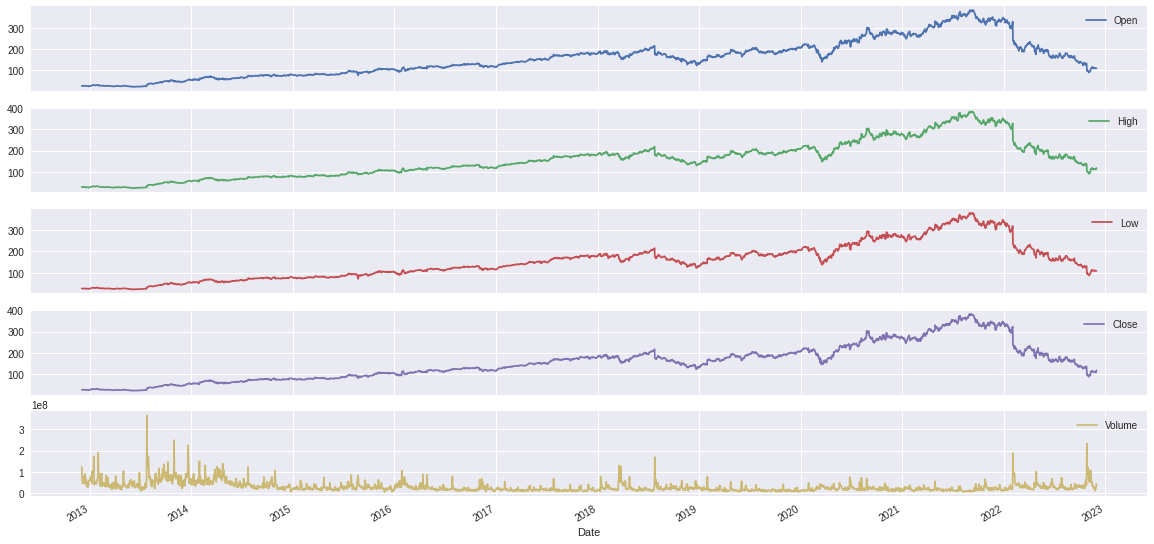

In [118]:
df.plot(x='Date',subplots=True, figsize=(20,10))

## Modeling

In [119]:
## Hyperparameters of TF 

batch_size = 32
seq_len = 128
d_k = 64 #256
d_v = 64 # 256
n_heads = 12
ff_dim = 64 #256

Normarilze & Train/Test Split

In [120]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (2013, 5)
Validation data shape: (252, 5)
Test data shape: (251, 5)


,Open,High,Low,Close,Volume
1,0.309386,0.299056,0.353903,0.406747,0.044899
2,0.426508,0.385949,0.419053,0.394001,0.070907
3,0.370948,0.365290,0.343946,0.323000,0.067450
4,0.332255,0.378093,0.377428,0.413811,0.108400
5,0.383274,0.403785,0.395157,0.401559,0.090887


In [121]:
df_train.describe()

,Open,High,Low,Close,Volume
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,0.378713,0.378576,0.378689,0.378742,0.102109
std,0.044602,0.038053,0.041753,0.043245,0.055542
min,0.000704,0.026867,0.000995,0.000000,0.000000
25%,0.357140,0.361775,0.360314,0.359117,0.069585
50%,0.377938,0.377234,0.379834,0.378297,0.090995
75%,0.399519,0.394009,0.397417,0.399568,0.120068
max,0.920229,1.000000,0.885911,0.963000,1.000000


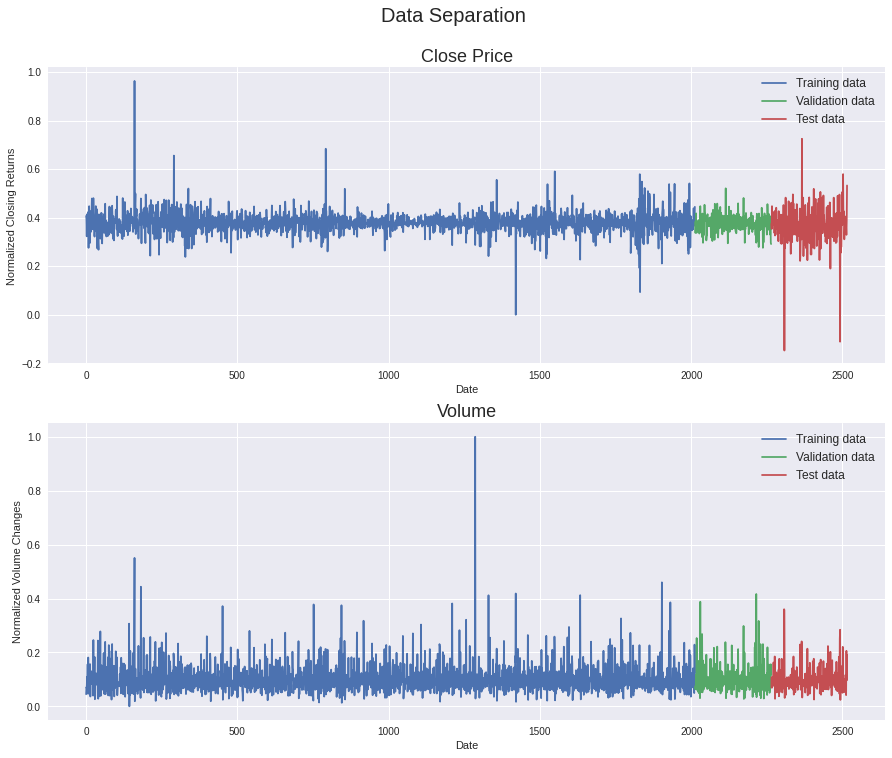

In [122]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)



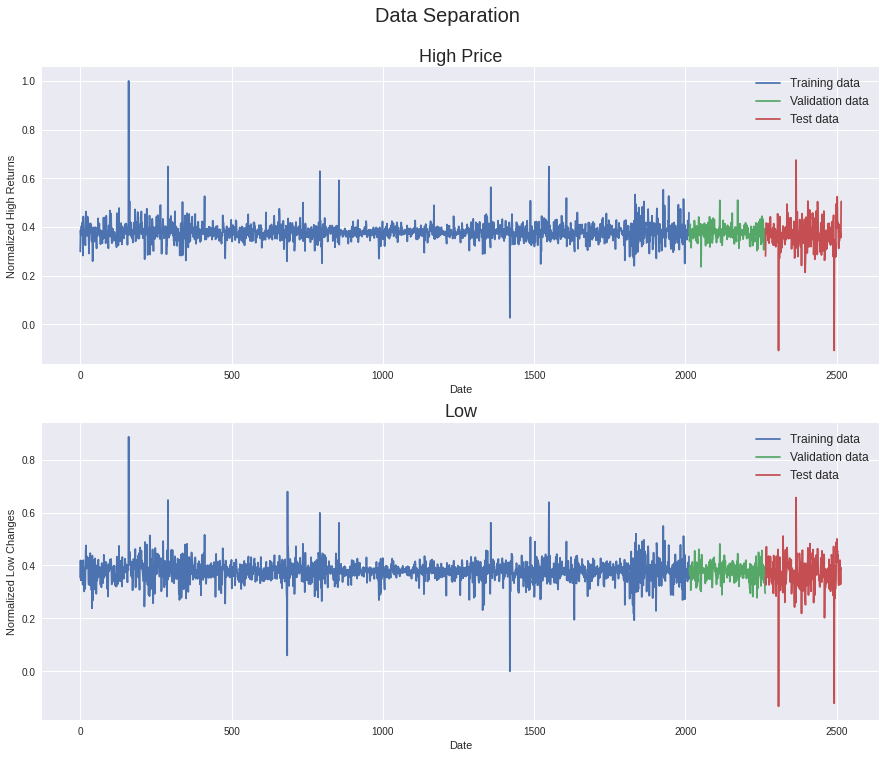

In [123]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['High'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['High'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['High'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized High Returns')
ax1.set_title("High Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Low'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Low'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Low'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Low Changes')
ax2.set_title("Low", fontsize=18)
ax2.legend(loc="best", fontsize=12)

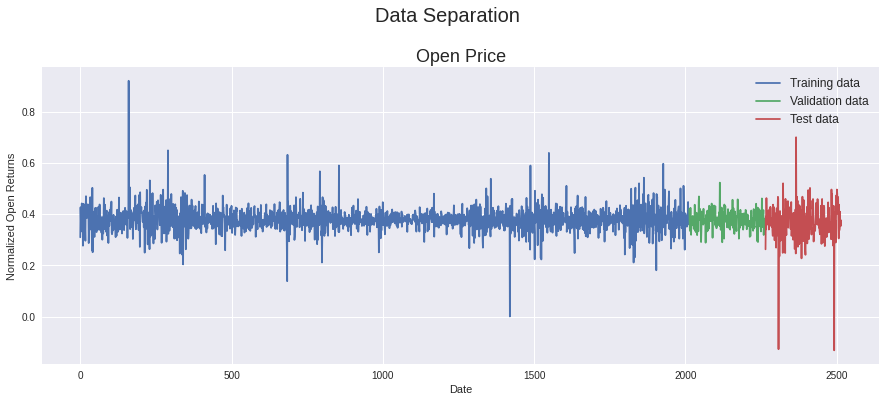

In [124]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Open'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Open'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Open'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Open Returns')
ax1.set_title("Open Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

## Preprocessing data train

In [125]:
df_train.describe()

,Open,High,Low,Close,Volume
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,0.378713,0.378576,0.378689,0.378742,0.102109
std,0.044602,0.038053,0.041753,0.043245,0.055542
min,0.000704,0.026867,0.000995,0.000000,0.000000
25%,0.357140,0.361775,0.360314,0.359117,0.069585
50%,0.377938,0.377234,0.379834,0.378297,0.090995
75%,0.399519,0.394009,0.397417,0.399568,0.120068
max,0.920229,1.000000,0.885911,0.963000,1.000000


In [126]:
df_train.Close = df_train.where(df_train.Close >0 ,0.1).Close

In [127]:
df_train.describe()

,Open,High,Low,Close,Volume
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,0.378713,0.378576,0.378689,0.378792,0.102109
std,0.044602,0.038053,0.041753,0.042866,0.055542
min,0.000704,0.026867,0.000995,0.093347,0.000000
25%,0.357140,0.361775,0.360314,0.359117,0.069585
50%,0.377938,0.377234,0.379834,0.378297,0.090995
75%,0.399519,0.394009,0.397417,0.399568,0.120068
max,0.920229,1.000000,0.885911,0.963000,1.000000


In [128]:
df_train.Volume = df_train.where(df_train.Volume !=0 ,0.005).Volume

In [129]:
df_train.describe()

,Open,High,Low,Close,Volume
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000
mean,0.378713,0.378576,0.378689,0.378792,0.102112
std,0.044602,0.038053,0.041753,0.042866,0.055538
min,0.000704,0.026867,0.000995,0.093347,0.005000
25%,0.357140,0.361775,0.360314,0.359117,0.069585
50%,0.377938,0.377234,0.379834,0.378297,0.090995
75%,0.399519,0.394009,0.397417,0.399568,0.120068
max,0.920229,1.000000,0.885911,0.963000,1.000000


## Training

In [130]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (1885, 128, 5) (1885,)
Validation set shape (124, 128, 5) (124,)
Testing set shape (123, 128, 5) (123,)


## Time vector

In [131]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

In [132]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model Training

In [133]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [134]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [135]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

# with tf.device('/device:GPU:0'):
model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=10, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector_3 (Time2Vector)   (None, 128, 2)       512         ['input_3[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 7)       0           ['input_3[0][0]',                
                                                                  'time2_vector_3[0][0]']         
                                                                                                  
 transformer_encoder_9 (Transfo  (None, 128, 7)      24810       ['concatenate_2[0][0]',    

4/4 [==============================] - 1s 221ms/step
 
Evaluation metrics
Training Data - Loss: 0.0019, MAE: 0.0281, MAPE: 199787.5625
Validation Data - Loss: 0.0012, MAE: 0.0264, MAPE: 7.2951
Test Data - Loss: 0.0064, MAE: 0.0542, MAPE: 17.9785


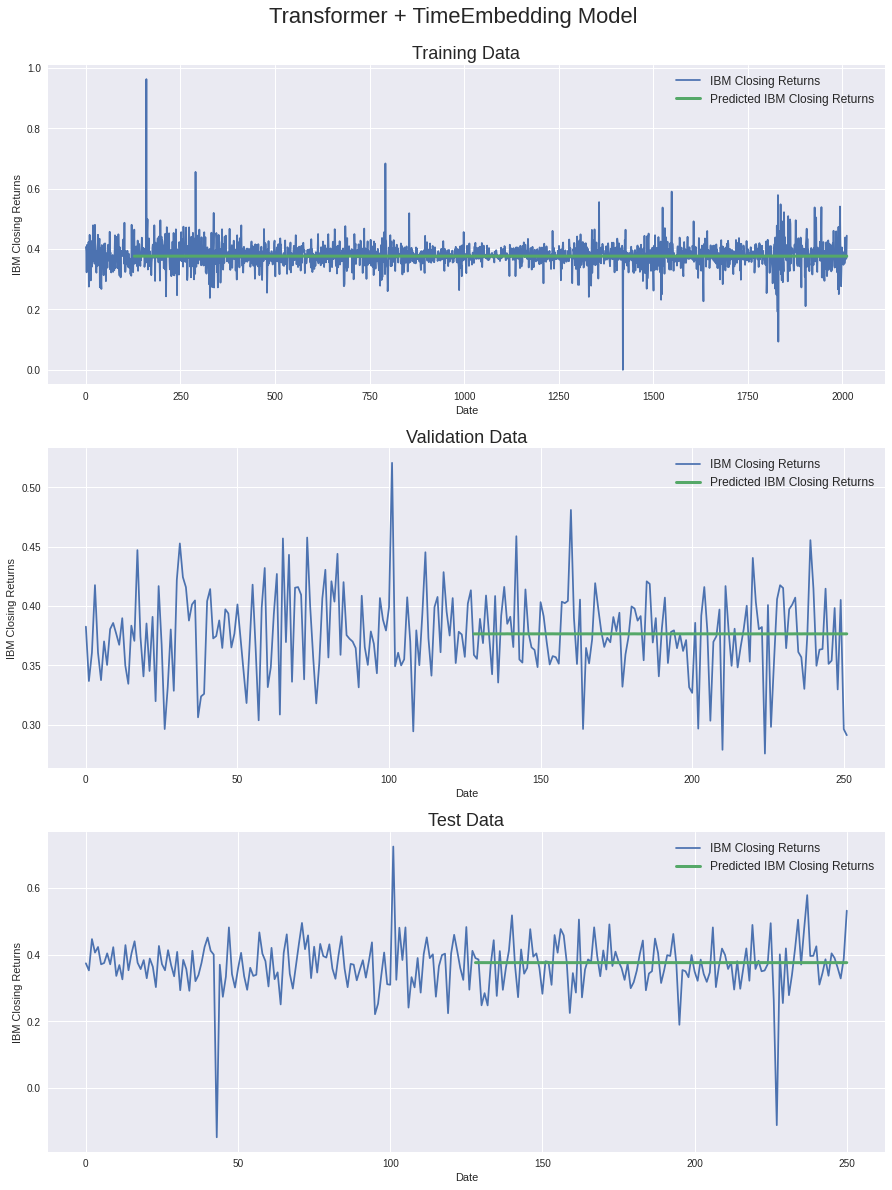

In [136]:
model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

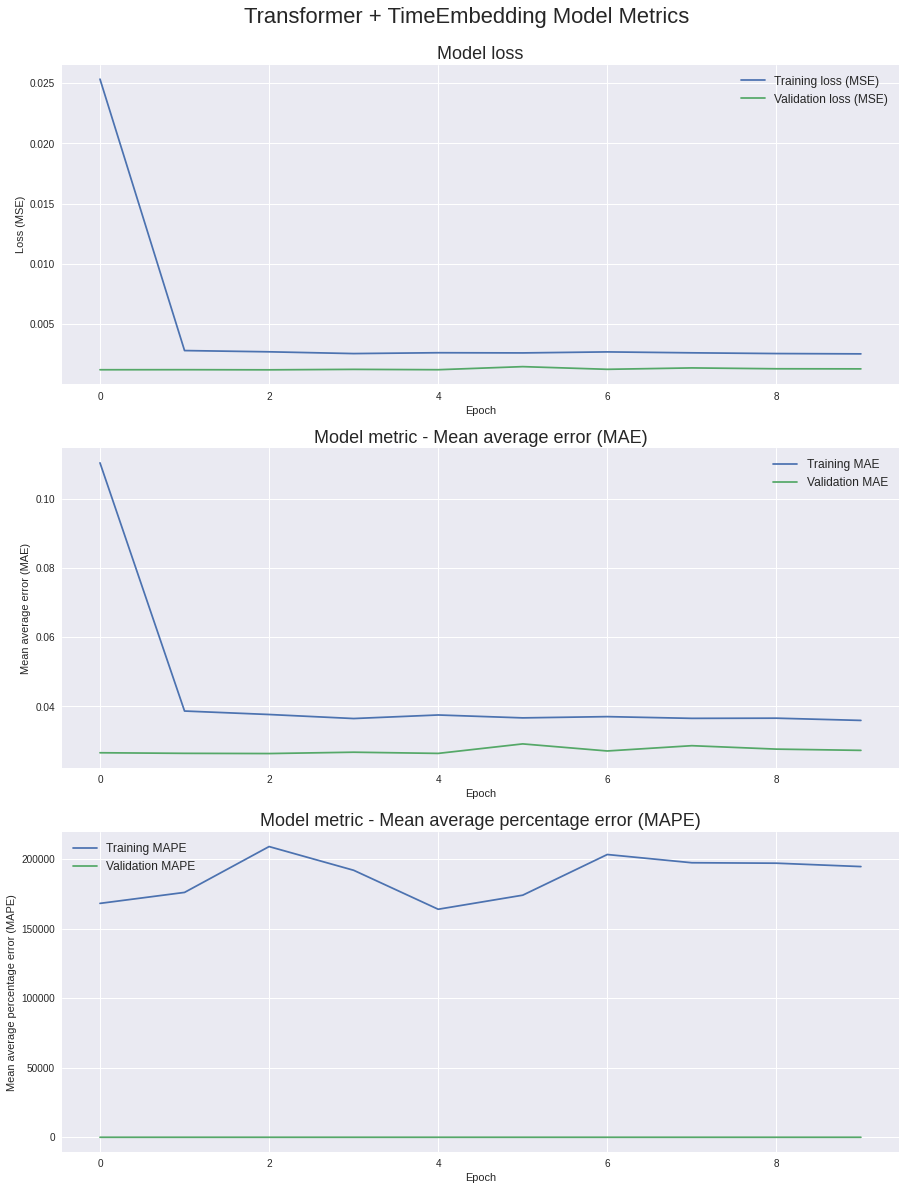

In [137]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)